# Домашнее задание к уроку 2

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [5]:
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
from nltk import ngrams
import nltk
from nltk import collocations 
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('genesis')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from string import punctuation
noise = stopwords.words('russian') + list(punctuation)

In [8]:
from collections import Counter

In [9]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:30]

2870536


['first_timee',
 'хоть',
 'я',
 'и',
 'школота',
 'но',
 'поверь',
 'у',
 'нас',
 'то',
 'же',
 'самое',
 'D',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'Да',
 'все-таки',
 'он',
 'немного',
 'похож',
 'на',
 'него',
 'Но',
 'мой',
 'мальчик',
 'все',
 'равно',
 'лучше']

In [10]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:30]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860),
 ('...', 22363),
 ('меня', 20656),
 ('у', 18928),
 ('как', 18279),
 ('так', 16839),
 ('D', 16575),
 ('это', 16542),
 ('мне', 16337),
 ('все', 14763),
 ('ты', 13412),
 ('но', 12949),
 ("''", 12471),
 ('Я', 12315),
 ('``', 11467),
 ('то', 11432),
 ('..', 11392),
 ('по', 11294),
 ('уже', 10180),
 ('за', 10038),
 ('же', 9628)]

-----

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

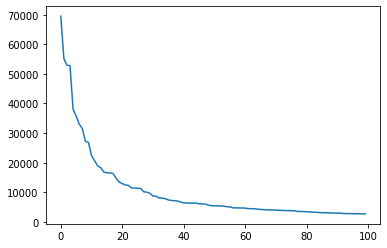

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

first_part_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_part_freqs)
plt.show()

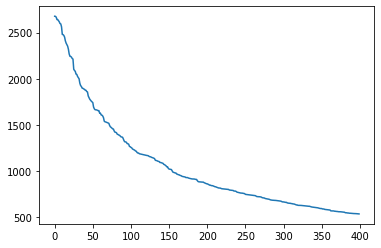

In [27]:
first_part_freqs = [freq for word, freq in freq_dict_sorted[100:500]]
plt.plot(first_part_freqs)
plt.show()

In [28]:
# Подготовим три группы токенов: с высокой, средней и низкой частотой

high_tokens = set()
med_tokens = set()
lit_tokens = set()
h = 17000 # если частота выше этого значения будем считать что это токен с высокой частотой. Выбор согласно графиков на предыдущих шагах.
m = 1000 # если частота ниже этого значения будем считать что это токен с низкой частотой. Выбор согласно графиков на предыдущих шагах.
for i in freq_dict_sorted:
    if i[1] > h:
        high_tokens.add(i[0])
    elif i[1] < m:
        lit_tokens.add(i[0])
    else:
        med_tokens.add(i[0])
print(len(high_tokens),len(med_tokens),len(lit_tokens))                     
                       

14 241 350868


In [29]:
# создадим фильтр (стопслова) с добавлением токенов средней и низкой частоты, 
# то есть будем считать только по токенам с высокой частотой
sw = noise + list(lit_tokens) + list(med_tokens)

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=sw)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.87      0.56      0.68     43044
    positive       0.34      0.72      0.47     13665

    accuracy                           0.60     56709
   macro avg       0.60      0.64      0.57     56709
weighted avg       0.74      0.60      0.63     56709

CPU times: user 1min 22s, sys: 8.08 s, total: 1min 30s
Wall time: 1min 23s


In [32]:
# посчитаем только по токенам с средней частотой
sw = noise + list(high_tokens) + list(lit_tokens)

In [33]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=sw)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.48      0.67      0.56     20207
    positive       0.76      0.60      0.67     36502

    accuracy                           0.62     56709
   macro avg       0.62      0.63      0.62     56709
weighted avg       0.66      0.62      0.63     56709

CPU times: user 1min 21s, sys: 8.92 s, total: 1min 30s
Wall time: 1min 23s


In [34]:
# посчитаем только по токенам с низкой частотой
sw = noise + list(high_tokens) + list(med_tokens)

In [35]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=sw)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.79      0.74      0.76     29787
    positive       0.73      0.78      0.75     26922

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

CPU times: user 1min 2s, sys: 14.2 s, total: 1min 16s
Wall time: 1min 4s


### Вывод:

Лучшая точность получилась на токенах с низкой частотностью, конечно есть зависимость от того как смещать границы разделения частотности.


## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
# Оставим знаки пунктуации  
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stopwords.words('russian'))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27941
    positive       1.00      1.00      1.00     28768

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [38]:
# похоже что существенный вклад дают симолы которые участвуют в смайлах. Проверим
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
p = list('"#$%&\'+,.<=>?@[\\]^`{|}~')
p

['"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '+',
 ',',
 '.',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '`',
 '{',
 '|',
 '}',
 '~']

In [40]:
myfilter = stopwords.words('russian') + p
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words= myfilter)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27917
    positive       1.00      1.00      1.00     28792

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Гипотеза подтверждается

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [41]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32814
    positive       0.83      1.00      0.91     23895

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.92     56709



In [42]:
pp = []
for i in punctuation:
    cool_token = i
    pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
    pp.append((i,accuracy_score(pred, y_test)))
print(pp)

[('!', 0.5188065386446595), ('"', 0.5053871519511894), ('#', 0.5041527799820135), ('$', 0.49348427939127826), ('%', 0.4958648539032605), ('&', 0.49350191327655224), ("'", 0.4934137438501825), ('(', 0.02571020472940803), (')', 0.9147930663563103), ('*', 0.5119116895025481), ('+', 0.49404856372004446), (',', 0.5026891675042762), ('-', 0.5109065580419334), ('.', 0.510113033204606), ('/', 0.5431413003227001), (':', 0.5455395087199563), (';', 0.49803382179195543), ('<', 0.4934313777354565), ('=', 0.493572448817648), ('>', 0.4934313777354565), ('?', 0.5055987585744767), ('@', 0.5676171330829322), ('[', 0.4935371810471001), ('\\', 0.4934490116207304), (']', 0.49359008270292193), ('^', 0.49879207885873494), ('_', 0.517166587314183), ('`', 0.49299053060360787), ('{', 0.4934137438501825), ('|', 0.48932268246662786), ('}', 0.4934490116207304), ('~', 0.49323740499744306)]


Фичи с наибольшей значимостью

In [43]:
for i in sorted(pp, key=lambda x: -x[1])[:10]:
    print(i[0],'  -   ' ,i[1])


)   -    0.9147930663563103
@   -    0.5676171330829322
:   -    0.5455395087199563
/   -    0.5431413003227001
!   -    0.5188065386446595
_   -    0.517166587314183
*   -    0.5119116895025481
-   -    0.5109065580419334
.   -    0.510113033204606
?   -    0.5055987585744767


----



### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [44]:
%%time
myfilter = stopwords.words('russian') + p

count_vect = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words= myfilter)
bow = count_vect.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       1.00      0.55      0.71     50487
    positive       0.22      1.00      0.36      6222

    accuracy                           0.60     56709
   macro avg       0.61      0.78      0.53     56709
weighted avg       0.91      0.60      0.67     56709

CPU times: user 1min 2s, sys: 13.4 s, total: 1min 15s
Wall time: 1min 4s


In [45]:
%%time
myfilter = stopwords.words('russian')
tf_vect = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words= myfilter)
bow = tf_vect.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(tf_vect.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27941
    positive       1.00      1.00      1.00     28768

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709

CPU times: user 1min 3s, sys: 12.2 s, total: 1min 15s
Wall time: 1min 5s


In [46]:
from sklearn.feature_extraction.text import HashingVectorizer

In [47]:
vectorizer = HashingVectorizer(n_features=2**4,)
bow = vectorizer.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vectorizer.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       0.51      0.54      0.52     26100
    positive       0.59      0.55      0.57     30609

    accuracy                           0.55     56709
   macro avg       0.55      0.55      0.55     56709
weighted avg       0.55      0.55      0.55     56709



In [48]:
vectorizer = HashingVectorizer(n_features=2**8,)
bow = vectorizer.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vectorizer.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       0.60      0.61      0.60     27522
    positive       0.62      0.61      0.62     29187

    accuracy                           0.61     56709
   macro avg       0.61      0.61      0.61     56709
weighted avg       0.61      0.61      0.61     56709



In [49]:
vectorizer = HashingVectorizer(n_features=2**10,)
bow = vectorizer.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vectorizer.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       0.64      0.65      0.64     27392
    positive       0.67      0.65      0.66     29317

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709



In [50]:
vectorizer = HashingVectorizer(n_features=2**12,)
bow = vectorizer.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vectorizer.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       0.68      0.69      0.68     27362
    positive       0.71      0.69      0.70     29347

    accuracy                           0.69     56709
   macro avg       0.69      0.69      0.69     56709
weighted avg       0.69      0.69      0.69     56709

